# Experiment: Million Songs Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,RidgeCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
import seaborn as sns

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

df=pd.read_csv('YearPredictionMSD.txt',header=None,sep = ',')
#smaller dataset
train=df.iloc[300000:300700] 
test=df.iloc[500000:500300] 

train_y = train[0]
test_y = test[0] #response:year
train_x = train
test_x = test
del train_x[0]
del test_x[0]
total_x=pd.concat([train_x,test_x])
x=preprocessing.StandardScaler().fit(total_x).transform(total_x) #normalize
x=pd.DataFrame(x)
train_x=x.iloc[:700]
test_x=x.iloc[700:]

train_x.reset_index(drop=True, inplace=True) 
test_x.reset_index(drop=True, inplace=True) 
train_y.reset_index(drop=True, inplace=True) 
test_y.reset_index(drop=True, inplace=True) 

train_x ##display the data

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,-1.169588,-0.913331,-1.303357,0.366642,-1.446675,-0.408470,0.866105,0.914454,-1.242843,-0.667838,...,0.207254,0.352000,-1.993373,-0.121706,-0.624721,-3.186580,2.233731,-1.497663,1.015620,1.535324
1,-0.384652,0.083956,-0.409324,0.340569,-0.922879,0.015633,1.158662,0.921513,0.571624,0.059751,...,2.548116,1.116907,-0.863423,-1.574714,1.571018,0.933343,-0.660936,0.018256,-0.441595,0.061384
2,-0.474117,1.071657,-2.011545,1.578102,-0.387551,0.668625,1.009691,-1.046157,0.164916,0.055518,...,-0.107606,-4.416389,6.454818,3.133579,4.412800,-6.273857,-2.294102,6.551096,-0.142954,-0.990494
3,-1.085627,1.033851,-1.001179,2.001694,0.231899,1.523338,1.051318,1.507985,-0.941449,-0.231110,...,0.101883,3.043570,1.424674,-1.320191,1.222839,0.278665,2.211740,0.589111,-2.269302,1.055646
4,-0.705294,-0.778753,-2.057925,-0.842471,0.976928,-0.353554,-0.405709,0.509083,0.569620,-0.519164,...,-1.579429,0.847409,-1.423293,0.122463,-0.858162,-1.384214,0.440914,-1.079154,-0.234252,0.420268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,-1.448799,0.325952,0.582353,0.258919,0.149646,-0.474193,-1.217127,-0.916761,0.088114,-0.320500,...,0.175976,-0.362254,-1.443022,-0.329998,-0.809020,-0.096618,-1.097373,1.158430,-0.030136,-0.139725
696,-0.743319,0.679493,-0.121131,0.266191,0.153593,0.116883,0.285190,0.262373,0.744065,1.012218,...,0.336759,-0.120216,-0.228381,-0.525685,0.470486,-0.179525,-0.485096,-0.265838,-0.166360,-0.097013
697,-1.079830,0.074670,-0.605215,-0.890968,0.940719,-0.745934,-2.093624,-0.008216,1.374812,1.199631,...,0.253918,0.084684,-0.654068,-0.514407,-0.104413,0.146940,-0.811716,0.178947,0.876225,0.210794
698,-0.628019,0.188730,0.035737,-0.332677,0.625774,-0.682705,0.116143,-0.111752,1.780001,0.683753,...,1.043273,0.018961,-0.808076,0.129063,-0.854428,0.051633,0.294883,0.436294,-0.226600,2.013739


In [3]:
len(df)

515345

In [2]:
nntrain_x = torch.from_numpy(train_x.to_numpy()).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float()) 
nntest_x= torch.from_numpy(test_x.to_numpy()).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

## 1. DNN

In [3]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(90, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-6,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
dnn_trainloss=[]
dnn_testloss=[]
t0=time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    
    if epoch>100 and float(test_loss)>max(dnn_testloss[-100:-1]):
        break
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    
    dnn_trainloss.append(float(train_loss))
    dnn_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=90, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3984438.0
            Test  set - loss: 4001260.5
            
epoch 100
            Train set - loss: 399.58258056640625
            Test  set - loss: 2541.88427734375
            
epoch 200
            Train set - loss: 151.03475952148438
            Test  set - loss: 915.9685668945312
            
epoch 300
            Train set - loss: 84.96205139160156
            Test  set - loss: 690.5421752929688
            
epoch 400
            Train set - loss: 58.495849609375
            Test  set - loss: 630.4786987304688
            
epoch 500
            Train set - loss: 59.73417663574219
            Test  set - loss: 593.3506469726562
            
epoch 600
            Train set - loss: 48.43214416503906
            Test  set - loss: 594.4166870117188
            
ep

In [4]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2009.8662 1995.0034 1995.8103 1993.2722 1967.9526 1995.616  1993.1023
 1984.5717 1956.053  2052.538  1998.8594 1996.1492 2007.8044 2094.8936
 1996.214  1998.3212 2023.0339 2007.9916 1996.6873 2006.2012 1992.9655
 2008.447  2003.084  2006.6176 2005.1211 1998.6244 1981.2644 1990.3889
 1988.553  1996.0564 1996.4429 1996.379  2000.3834 2000.4506 1990.8502
 1991.5233 2005.4056 1986.5293 1993.7524 1994.9631 2021.8197 1974.8461
 1985.6997 1996.3734 1986.5724 2138.2334 1967.6622 2008.169  2167.4866
 1949.4005 1975.5488 1930.982  2004.7349 2008.4417 2028.6278 2036.2114
 2010.0999 2016.37   2001.7365 2001.4053 2002.6829 1998.3738 2006.5432
 2004.5957 1998.7206 2001.4896 2004.5957 2002.9324 2006.0273 1963.497
 2013.3618 1960.0719 1977.1788 1973.7478 1971.0902 1973.0684 2063.8765
 2059.8442 2046.7124 2157.7136 2078.3716 1982.5956 2017.4602 1976.3568
 1978.8015 1991.0945 2047.4651 2023.1187 1992.7375 1979.336  2054.2236
 2002.4612 1983.9093 1998.103  1990.9263 1996.8903 2010.292  1995.9662
 1996.7

In [ ]:
#bootstrap  
boottime=80
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = Net()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-6,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
    dnn_testloss=[]
    t0=time.time()
    for epoch in range(2000): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred,y)
        
        if epoch>100 and float(test_loss)>max(dnn_testloss[-100:-1]):
            break
        dnn_testloss.append(float(test_loss))
    
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

100%|██████████| 80/80 [27:22<00:00, 20.54s/it]


In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,77]-bootbase)
upper=bootbase-(sorted_bootlist[:,2]-bootbase)
print("confidence interval length",sorted_bootlist[:,77]-sorted_bootlist[:,2])
dnn_length=(sorted_bootlist[:,77]-sorted_bootlist[:,2]).mean()
print("average confidence interval length",dnn_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
dnn_coverage=cover/300
print("95 coverage",dnn_coverage)

confidence interval length [ 67.00256   60.99182   45.463013 105.73218  187.40955   40.641357
  49.288086  60.26367  222.00671  132.18457   47.295288  99.760376
  98.47058  355.99426   76.5459    39.533203 127.91785   37.11438
  28.20105   42.63977  216.18689   65.93042  163.328     47.145508
  40.878784  67.40332   23.32727   34.037354  35.56311   60.11084
  56.902832  47.33789   22.056519  25.358276  31.638916  31.018066
  29.340332  45.236572  49.982178  41.777588 105.631714 149.1908
  81.800415 357.7124   293.4297   400.0465   154.99194  182.0747
 305.37256  281.00854  234.62744  189.51526   91.23901   96.84241
  74.44055  180.68811   95.53381   97.27893  114.309204 197.25256
 200.66138  192.4364   207.84229  203.75916   74.39722   92.829834
 203.75916  127.317505 210.44397   94.66382  133.7533   115.42554
 158.93555   69.823     79.24939   80.24817  365.03394  344.56897
 265.16003  655.33594  284.73877  186.48438  143.53125   67.03088
  68.9541   204.08472  335.02747   64.10181   

## 2. Resnet

In [4]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(infeatures,outfeatures)
    
    def forward(self, x):
        y = self.fc1(x)
        y= F.relu(y)
        x = self.fc2(x)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.rblock1 = ResidualBlock(90,32)
        self.rblock2 = ResidualBlock(32,8)
        self.fc3 = nn.Linear(8,1)
    
 
    def forward(self, x):
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-7,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
res_trainloss=[]
res_testloss=[]
t0=time.time()
for epoch in range(4000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    
    if epoch>100 and float(test_loss)>max(res_testloss[-100:-1]):
        break
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    res_trainloss.append(float(train_loss))
    res_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("ResNet complexity and model fitted in %.3f s" % dnn_fit)

ResNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=90, out_features=32, bias=True)
    (fc2): Linear(in_features=90, out_features=32, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
  )
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3977215.0
            Test  set - loss: 4000395.25
            
epoch 100
            Train set - loss: 3124.539794921875
            Test  set - loss: 11475.6611328125
            
epoch 200
            Train set - loss: 886.2252197265625
            Test  set - loss: 4481.39892578125
            
epoch 300
            Train set - loss: 388.1315612792969
            Test  set - loss: 2702.1875
            
epoch 400
            Train set - loss: 172.0522918701172
            Test  set - loss: 2024.3753662109375
            
epoch 500
            Train set - loss: 175.758941650

In [7]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2036.0021 1979.0992 1982.1678 1992.9504 2033.2422 1990.5587 1991.5238
 1993.0455 1956.7035 2024.8884 1993.752  1971.9182 1984.7587 2086.38
 1968.6139 1988.6139 1986.6417 1998.078  1986.9368 2000.8453 2033.6958
 2011.2865 2006.9769 2001.4838 2003.9198 2010.8566 1982.2084 1988.6368
 1985.7222 1989.421  1977.5104 2000.0085 1997.0186 1998.6189 1985.6687
 1983.4315 1995.4008 1979.2738 1991.8075 1994.5906 2008.23   1972.63
 1986.6146 2040.8832 2007.1626 2092.922  1976.346  2047.3496 2215.3137
 1954.6752 1992.9725 1988.4978 2024.0548 1996.4207 2029.138  2004.4126
 1968.8516 2069.4358 1979.4874 2065.613  2066.519  2061.6912 2070.9036
 2069.4202 1995.1963 2047.2445 2069.4202 2065.765  2072.5208 1975.1646
 1975.4065 1961.1183 1969.0084 1966.1976 1963.385  1956.0413 2101.5544
 2043.2462 2033.6702 2086.1375 1997.1833 1979.5021 1989.474  1959.811
 1986.4248 2000.9965 1964.7544 1995.0864 2003.7578 1989.6285 2013.7294
 2014.4161 1968.5372 2005.7827 1982.3655 1992.0304 2042.7592 1984.8749
 1987.1105 

In [ ]:
#bootstrap  
boottime=80
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResNet()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-7,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
    res_testloss=[]
    t0=time.time()
    for epoch in range(4000):  
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred,y)
        
        if epoch>100 and float(test_loss)>max(res_testloss[-100:-1]):
            break
        res_testloss.append(float(test_loss))
            
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

100%|██████████| 80/80 [1:16:25<00:00, 57.32s/it]


In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,77]-bootbase)
upper=bootbase-(sorted_bootlist[:,2]-bootbase)
print("confidence interval length",sorted_bootlist[:,77]-sorted_bootlist[:,2])
resnet_length=(sorted_bootlist[:,77]-sorted_bootlist[:,2]).mean()
print("average confidence interval length",resnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
resnet_coverage=cover/300
print("95 coverage",resnet_coverage)

confidence interval length [ 91.24475   82.83154   62.97766  108.848145 163.98572   48.860596
  68.57422   91.62158  146.61694  112.02893   55.386963 107.578
  75.56201  380.45837   81.66504   48.884644  94.85303   41.63501
  38.731934  43.496094 188.48608   75.74841  118.720215  67.242676
  60.298462  74.36316   36.021484  25.378662  42.623413  58.584473
  67.74158   62.881104  27.970947  33.586304  34.0094    46.95337
  43.57373   51.59497   58.186157  37.975586 116.232666 111.09387
 134.71399  428.6919   284.81836  340.1172   162.17908  179.57434
 287.3108   383.43884  216.92896  148.6305   101.88306   81.632324
  82.28577  155.66199   69.056274 137.0426   124.19299  220.83386
 220.65063  223.29517  222.2843   221.5863    82.84924   85.65674
 221.5863   118.88269  219.82373   98.74072  142.6106   132.35693
 110.49182   59.833984  88.326904 100.46936  346.6443   292.86682
 285.05896  594.76196  261.93677  181.11841  143.61084   70.95911
  70.32837  158.66638  260.6626    60.321777  5

## Random Feature

definition of random feature

In [4]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=np.random.randn(1)*gamma
        return w
    elif pdf=='L':
        w=np.random.laplace(1)*gamma
        return w
    elif pdf=='C':
        w=np.random.standard_cauchy(1)*gamma
        return w
    

def sample(pdf, gamma, d):
    return [sample_1d(pdf, gamma) for _ in range(d)]


class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : np.array
        shape (D,d)
    b : np.array
        shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = np.random.uniform(0, 2 * np.pi, self.D)
        self.W = np.reshape(
            np.array([
                sample(self.kernel, self.gamma, self.d)
                for _ in range(self.D)], dtype=np.float32),
            (self.D, self.d))

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : np.array (shape=(n,d))
            Array to transform; must be single dimension vector
        Returns
        -------
        x : np.array (shape=(n,D))
            Feature space transformation of x
        """
        x=pd.DataFrame(x)
        result=np.array([
            np.sqrt(2 / self.D) * np.cos(np.dot(self.W, x.iloc[i]) + self.b) for i in range(len(x))]
            )            
        return result

Linear regression vs single layer random feature model

In [4]:
model =LinearRegression()
model.fit(train_x, train_y)
y_pretest=model.predict(test_x)
y_pretrain=model.predict(train_x)
print("Linear Ridge train mse:",mean_squared_error(train_y,y_pretrain))
print("test mse:",mean_squared_error(test_y,y_pretest))

score=[]
trainmse=[]
testmse=[]
gaset=np.linspace(0.1,0.5,100)
for ga in gaset:
    rff=RandomFourierFeature(90,30,kernel='G',gamma=ga)
    total_x=pd.concat([train_x,test_x])
    feature=rff.transform(total_x)
    train_xtransformed=feature[:len(train_x)]
    test_xtransformed=feature[len(train_x):]
    model.fit(train_xtransformed, train_y)
    y_pretest=model.predict(test_xtransformed)
    y_pretrain=model.predict(train_xtransformed)
    score.append(cross_val_score(model,train_xtransformed,train_y,cv=5).mean())   ##cross-validation
    trainmse.append(mean_squared_error(y_pretrain,train_y))
    testmse.append(mean_squared_error(y_pretest,test_y))
ind=score.index(max(score))
print("cv-score,index,gamma,trainmse,testmse",max(score),ind,gaset[ind],trainmse[ind],testmse[ind])

Linear Ridge train mse: 74.86242454318058
test mse: 154.0442425294812
cv-score,index,gamma,trainmse,testmse -0.8127628920566228 24 0.19696969696969696 111.46234756430648 193.05861797235377


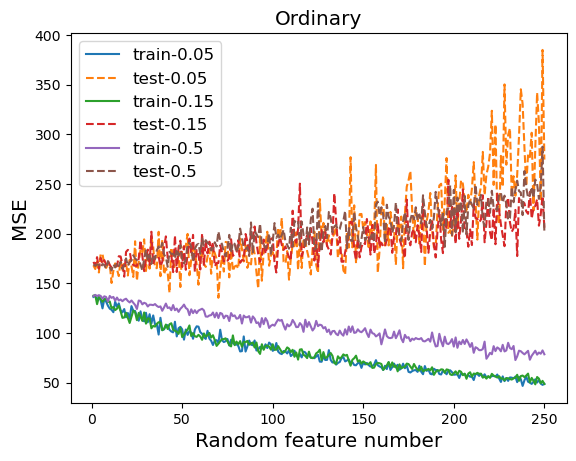

In [24]:
model =LinearRegression() #without bagging
Layer=1
m0set=np.linspace(1,250,250)
m0set=m0set.astype(int)
gaset=[0.05,0.15,0.5]

for ga in gaset:
    trainmse=[]
    testmse=[]
    t=[]
    for m0 in m0set:  
        rff=RandomFourierFeature(90,m0,kernel='G',gamma=ga)
        total_x=pd.concat([train_x,test_x])
        feature=rff.transform(total_x)
        train_xtransformed=feature[:700]
        test_xtransformed=feature[700:]
            
        model.fit(train_xtransformed, train_y)
        y_pretest=model.predict(test_xtransformed)
        y_pretrain=model.predict(train_xtransformed)
        
        trainmse.append(mean_squared_error(train_y,y_pretrain))
        testmse.append(mean_squared_error(test_y,y_pretest))

    plt.plot(m0set,trainmse)
    plt.plot(m0set,testmse,linestyle='dashed')
    

plt.xlabel("Random feature number",fontsize="x-large")
plt.ylabel("MSE",fontsize="x-large")
plt.title("Ordinary",fontsize="x-large")
plt.legend(["train-0.05","test-0.05","train-0.15","test-0.15","train-0.5","test-0.5"],loc="upper left",fontsize="large")
plt.show()

100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


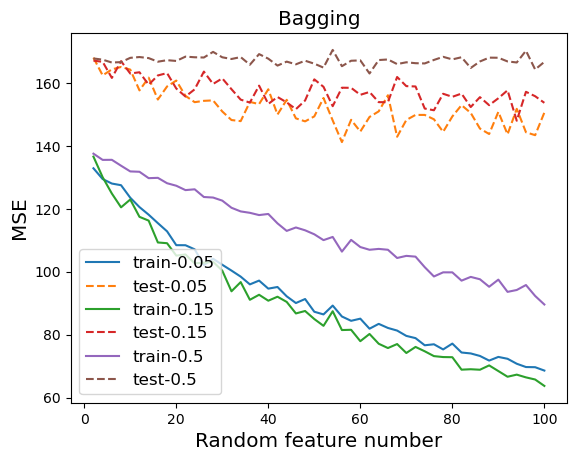

In [23]:
model =LinearRegression() #bagging
Layer=1
m0set=np.linspace(2,100,50)
m0set=m0set.astype(int)
gaset=[0.05,0.15,0.5]
n0=16

for ga in gaset:
    trainmse=[]
    testmse=[]
    t=[]
    for m0 in tqdm(m0set):  
        for i in range(n0):
            rff=RandomFourierFeature(90,m0,kernel='G',gamma=ga)
            total_x=pd.concat([train_x,test_x])
            feature=rff.transform(total_x)
            train_xtransformed=feature[:700]
            test_xtransformed=feature[700:]
            
            model.fit(train_xtransformed, train_y)
            if i==0:
                y_pretest=model.predict(test_xtransformed)
                y_pretrain=model.predict(train_xtransformed)
            else:
                y_pretest=y_pretest+model.predict(test_xtransformed)
                y_pretrain=y_pretrain+model.predict(train_xtransformed) 
        
        y_pretest=y_pretest/n0
        y_pretrain=y_pretrain/n0
        
        trainmse.append(mean_squared_error(train_y,y_pretrain))
        testmse.append(mean_squared_error(test_y,y_pretest))

    plt.plot(m0set,trainmse)
    plt.plot(m0set,testmse,linestyle='dashed')
    

plt.xlabel("Random feature number",fontsize="x-large")
plt.ylabel("MSE",fontsize="x-large")
plt.title("Bagging",fontsize="x-large")
plt.legend(["train-0.05","test-0.05","train-0.15","test-0.15","train-0.5","test-0.5"],loc="lower left",fontsize="large")
plt.show()

In [ ]:
model =Ridge(alpha=1)
model.fit(train_x, train_y)
y_pretest=model.predict(test_x)
y_pretrain=model.predict(train_x)
print("Linear Ridge train mse:",mean_squared_error(train_y,y_pretrain))
print("test mse:",mean_squared_error(test_y,y_pretest))

score=[]
trainmse=[]
testmse=[]
gaset=np.linspace(0,0.3,100)
for ga in gaset:
    rff=RandomFourierFeature(90,2000,kernel='G',gamma=ga)
    total_x=pd.concat([train_x,test_x])
    feature=rff.transform(total_x)
    train_xtransformed=feature[:len(train_x)]
    test_xtransformed=feature[len(train_x):]
    model.fit(train_xtransformed, train_y)
    y_pretest=model.predict(test_xtransformed)
    y_pretrain=model.predict(train_xtransformed)
    score.append(cross_val_score(model,train_xtransformed,train_y,cv=5).mean())   ##cross-validation
    trainmse.append(mean_squared_error(y_pretrain,train_y))
    testmse.append(mean_squared_error(y_pretest,test_y))
ind=score.index(max(score))
print("cv-score,index,gamma,trainmse,testmse",max(score),ind,gaset[ind],trainmse[ind],testmse[ind])

Linear Ridge train mse: 74.86409656538211
test mse: 153.7107056787628
cv-score,index,gamma,trainmse,testmse -0.4808480141674825 46 0.1393939393939394 46.73350973569064 152.42049196114354


one single gaussian kernel machine

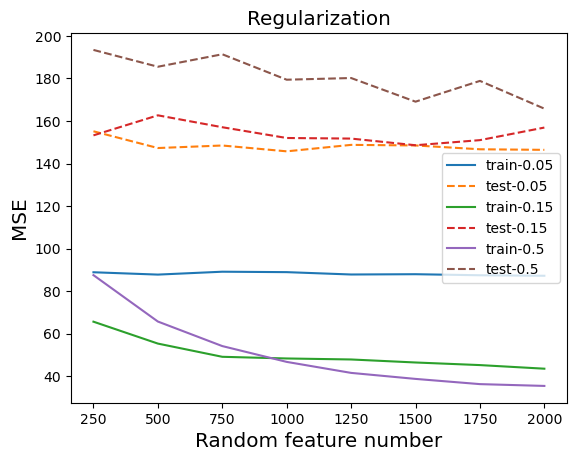

In [26]:
model=Ridge(alpha=1)
Layer=1
m0set=np.linspace(250,2000,8)
m0set=m0set.astype(int)
gaset=[0.05,0.15,0.5]

for ga in gaset:
    trainmse=[]
    testmse=[]
    t=[]
    for m0 in m0set:  
        rff=RandomFourierFeature(90,m0,kernel='G',gamma=ga)
        total_x=pd.concat([train_x,test_x])
        feature=rff.transform(total_x)
        train_xtransformed=feature[:700]
        test_xtransformed=feature[700:]
            
        model.fit(train_xtransformed, train_y)
        y_pretest=model.predict(test_xtransformed)
        y_pretrain=model.predict(train_xtransformed)
        
        trainmse.append(mean_squared_error(train_y,y_pretrain))
        testmse.append(mean_squared_error(test_y,y_pretest))

    plt.plot(m0set,trainmse)
    plt.plot(m0set,testmse,linestyle='dashed')
    

plt.xlabel("Random feature number",fontsize="x-large")
plt.ylabel("MSE",fontsize="x-large")
plt.title("Regularization",fontsize="x-large")
plt.legend(["train-0.05","test-0.05","train-0.15","test-0.15","train-0.5","test-0.5"],loc="right")
plt.show()

# 3. new

In [3]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=torch.randn(1)*gamma
        return w
    elif pdf=='L':
        w=torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    elif pdf=='C':
        w=torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    
def sample(pdf, gamma, d):
    return torch.tensor([sample_1d(pdf, gamma) for _ in range(d)])

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = torch.rand(self.D)*2*torch.pi
        self.W = sample(self.kernel, self.gamma, self.d*self.D).reshape(self.D,self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
        #print(self.W.shape,self.b.reshape(-1,1).shape,x.shape)
        #print((self.W @ x.T).shape)
       
        result=torch.sqrt(torch.tensor([2.0/self.D])) * torch.cos( self.W @ x.T  + (self.b.reshape(-1,1) @ torch.ones(len(x)).reshape(1,-1))) 
        #print(result.T.shape)
        return result.T

In [66]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff1=RandomFourierFeature(90,32,kernel='C',gamma=0.01)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=0.1)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(32, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=8e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)

        test_loss = criterion(y_test_pred,y)
            
    if epoch>100 and float(test_loss)>max(kernelnn_testloss[-100:-1]):
        break
    
    
    if epoch % 100 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
   
    kernelnn_trainloss.append(float(train_loss))
    kernelnn_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3533019.75
            Test  set - loss: 3504774.5
            
epoch 100
            Train set - loss: 918.152099609375
            Test  set - loss: 2731.4970703125
            
epoch 200
            Train set - loss: 295.9398498535156
            Test  set - loss: 1187.7822265625
            
epoch 300
            Train set - loss: 170.44557189941406
            Test  set - loss: 574.872314453125
            
epoch 400
            Train set - loss: 182.57106018066406
            Test  set - loss: 322.8010559082031
            
epoch 500
            Train set - loss: 97.61880493164062
            Test  set - loss: 207.0792999267578
            
epoch 600
            Train set - loss: 103.53607177734375
            Test  set - loss: 152.2183074951172
            
epoch 700
            Train set - loss: 104.2321701049804

In [67]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2007.6193 2005.5917 1989.3755 1971.0865 2003.4675 1985.073  1977.6952
 1977.2122 1998.5532 1975.7217 1987.2213 1997.7593 1993.7188 1976.3467
 1991.4386 1987.3778 1969.0457 2003.6023 2003.7849 2001.4072 1999.5392
 1983.1343 2013.9344 2001.0593 1998.4359 1992.1344 1993.454  1976.574
 1996.3032 2000.9453 1993.5471 1986.7045 1999.1062 1997.4403 1991.4888
 2000.407  2005.9374 1987.3992 1989.7928 1993.6042 2007.6414 1993.2493
 1998.8939 2009.0879 1999.3496 2007.7867 2002.0029 2009.0486 2001.8885
 1993.4314 1998.1488 2001.3822 1995.4672 1983.8605 2000.9805 1993.779
 1994.9812 1992.7773 2003.7448 1997.3798 1989.0582 1999.2323 1994.2039
 2008.2668 2009.5852 1998.8582 2008.2668 1995.4939 2006.2688 1992.7695
 2003.2415 2006.0082 1982.3384 2000.9288 2002.4707 1993.3677 1995.4584
 1998.9556 1988.7812 2001.2112 1998.4225 1995.784  1996.334  1997.0657
 2005.1042 1996.2563 1992.356  1993.8732 1998.8969 1990.1382 1994.5802
 1999.6783 1985.2955 1997.4304 2005.2606 1997.559  1981.9364 1996.8458
 1988.54

In [86]:
#original
#predict
par=optimizer.param_groups[0]['params']

for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)

temp=torch.linalg.inv(Fi.T @ Fi)

length=[]
coverage=0
mark=0
for i in range(len(test_x)):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    length.append(2*1.96*np.sqrt(float(fFFf+1))*np.sqrt(kernelnn_trainloss[-1]))
    
    #coverage
    if pred.detach().numpy()[0][0]-1.96*np.sqrt(float(fFFf+1))*np.sqrt(kernelnn_trainloss[-1])<test_y[i] and pred.detach().numpy()[0][0]+1.96*np.sqrt(float(fFFf+1))*np.sqrt(kernelnn_trainloss[-1])>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)


torch.Size([700, 273])
n-p: 427  mark: 300
length 53.358932708416916
95 coverage 0.9566666666666667


In [87]:
#penalty
#predict
wei=1e-4
par=optimizer.param_groups[0]['params']

for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)


temp2=torch.linalg.inv(Fi.T @ Fi+wei *np.eye(Fi.T.shape[0]))
temp2=temp2.float()
temp=temp2@Fi.T @ Fi@temp2
p=Fi @temp2 @Fi.T
print(len(train_x)-np.trace(2*p-p@p))
corr=(len(train_x)-f0.shape[0])/(len(train_x)-np.trace(2*p-p@p))

length=[]
coverage=0
mark=0
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=1.96*np.sqrt(float(fFFf+1))*np.sqrt(kernelnn_trainloss[-1])*corr
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 700/700 [00:00<00:00, 1803.74it/s]


torch.Size([700, 273])
427.88507080078125


100%|██████████| 300/300 [00:00<00:00, 1608.42it/s]

n-p: 427  mark: 300
length 52.639089686642755
95 coverage 0.9533333333333334


In [88]:
##conformal prediction
#predict
par=optimizer.param_groups[0]['params']
for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-train_y[i])/np.sqrt(kernelnn_trainloss[-1])/np.sqrt(fFFf+1)])
    if fFFf < 0:
        continue
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(train_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]



mark=0
length=[]
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 700/700 [00:00<00:00, 1258.55it/s]


666.0


100%|██████████| 300/300 [00:00<00:00, 1369.80it/s]

length 52.34927124023437
95 coverage 0.9565111111111111


In [90]:
##conformal prediction
#predict
x0=torch.from_numpy(train_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    score=np.abs(pred.reshape(-1)-train_y[:].to_numpy())
sorted_score, sorted_indices=torch.sort(score)
q=(len(train_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]

coverage=0
for i in range(len(test_x)):
    if pred.detach().numpy()[0][0]-a<test_y[i] and pred.detach().numpy()[0][0]+a>test_y[i]:
        coverage=coverage+1
coverage=coverage/len(test_x)

print("length",2*a)
print("95 coverage",coverage)



666.0
length tensor(45.4880, dtype=torch.float64)
95 coverage 0.8533333333333334


In [68]:
#bootstrap  
boottime=80
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = KernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=8e-4,momentum=0.9) #optim.Adam(...)
    kernelnn_testloss=[]
    t0 = time.time()
    for epoch in range(2000): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            loss.append(train_loss)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred,y)
        
        if epoch>100 and float(test_loss)>max(kernelnn_testloss[-100:-1]):
            break
        kernelnn_testloss.append(float(test_loss))
                
            
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

100%|██████████| 80/80 [48:49<00:00, 36.62s/it]


In [69]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,77]-bootbase)
upper=bootbase-(sorted_bootlist[:,2]-bootbase)
print("confidence interval length",sorted_bootlist[:,77]-sorted_bootlist[:,2])
kernelnet_length=(sorted_bootlist[:,77]-sorted_bootlist[:,2]).mean()
print("average confidence interval length",kernelnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
kernelnet_coverage=cover/300
print("95 coverage",kernelnet_coverage)

confidence interval length [59.984253 62.299805 56.494995 67.81824  60.799194 52.088623 68.24963
 44.880737 49.683228 51.281616 55.037476 51.99707  44.986084 55.555786
 50.700317 52.11743  56.400024 45.607056 56.74878  55.84131  54.989136
 54.376953 57.250977 44.96631  47.994263 49.993774 46.43396  55.36267
 50.993164 59.71814  44.873657 44.512573 47.61914  47.582886 49.682617
 54.4386   51.12268  44.924316 42.856934 44.999023 54.867554 57.200684
 46.47119  43.24756  52.73584  55.451904 51.21997  53.335327 55.098633
 48.027466 55.23706  44.177856 46.409546 49.419556 47.517822 53.589478
 45.94519  56.342285 55.348633 51.65454  50.608154 46.06494  54.786865
 57.435547 47.584106 44.527466 57.435547 65.89514  47.776855 58.183105
 50.3584   47.66028  47.595825 52.149536 50.437134 46.347046 53.920044
 44.384644 47.68579  52.165283 53.856445 53.817383 45.576416 50.545654
 50.333252 48.12744  58.193848 63.769897 53.870605 57.41272  52.36084
 50.34204  53.44458  62.085693 53.466797 48.375244 51

# 4. new

In [21]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff0=RandomFourierFeature(90,32,kernel='C',gamma=0.01)
rff1=RandomFourierFeature(8,8,kernel='G',gamma=0.1)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(32,8,rff1)
        self.fc2 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        return self.fc2(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
#net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-7,momentum=0.9) #optim.Adam(...)

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(3000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)

        test_loss = criterion(y_test_pred,y)
            
    if epoch>100 and float(test_loss)>max(reskernel_testloss[-100:-1]):
        break
    
    
    if epoch % 100 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    reskernel_trainloss.append(float(train_loss))
    reskernel_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3985905.25
            Test  set - loss: 4002580.5
            
epoch 100
            Train set - loss: 230.1983642578125
            Test  set - loss: 126.36941528320312
            
epoch 200
            Train set - loss: 131.5525360107422
            Test  set - loss: 99.8614273071289
            
epoch 300
            Train set - loss: 181.56362915039062
            Test  set - loss: 79.61308288574219
            
epoch 400
            Train set - loss: 143.67349243164062
            Test  set - loss: 71.06195831298828
            
epoch 500
            Train set - loss: 132.6280517578125
            Test  set - loss: 68.73678588867188
            
Residual KernelNet complexity and model fitted in 9.846 s


In [ ]:
#prune
parameters_to_prune = (
    (net.rblock1.fc1, 'weight'),
    (net.rblock1.fc2, 'weight'),
    (net.rblock2.fc1, 'weight'),
    (net.rblock2.fc2, 'weight'),
    (net.fc3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

prune.remove(net.rblock1.fc1, 'weight')
prune.remove(net.rblock1.fc2, 'weight')
prune.remove(net.rblock2.fc1, 'weight')
prune.remove(net.rblock2.fc2, 'weight')
prune.remove(net.fc3, 'weight')

for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    y_test_pred = net(x)
    y_test_pred = torch.squeeze(y_test_pred)
        
    test_loss = criterion(y_test_pred,y)
print(f'''epoch {epoch}
        Train set - loss: {train_loss}
        Test  set - loss: {test_loss}
        ''')

In [22]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2002.8527 1996.4958 1991.7573 1993.4287 2000.2618 1989.5938 1986.6104
 1987.9799 1996.5364 2002.0441 1984.821  1998.5062 1994.4554 2001.1166
 1999.5045 1994.453  1994.8453 1996.8909 1989.9752 1996.7708 1999.9192
 2001.1261 1996.3246 1999.2092 1995.8746 1996.4485 1991.8096 1988.4419
 1995.1282 1994.1461 1992.1969 1993.7781 1999.0536 1996.2479 1983.3173
 1990.5253 1990.0759 2001.7999 1996.5441 1996.9758 2000.6117 1997.129
 1996.3851 2004.5847 2001.8605 1994.893  2003.8162 2002.7339 1996.1975
 1994.4075 2002.4365 1999.6766 1996.8566 1989.1926 2001.4725 2000.4221
 2002.8556 1994.3975 1996.2004 1999.4832 1999.4698 1998.5677 1999.2847
 1999.1742 1999.4695 2001.8024 1999.1742 1998.8163 1999.5199 1997.491
 2004.1598 1997.4073 1998.9272 1994.368  2000.774  2000.1624 2002.9247
 2003.7739 2004.5112 1982.5322 1996.25   1995.769  1994.287  1998.3892
 2006.2211 1993.5146 1998.4897 2001.1332 1989.7114 1993.1754 2000.0724
 2003.2938 1990.3795 1996.888  1990.188  1991.3741 1999.1818 1990.5802
 1994.04

In [24]:
#original
#predict
par=optimizer.param_groups[0]['params']

for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)

temp=torch.linalg.pinv(Fi.T @ Fi)

length=[]
coverage=0
mark=0
for i in range(len(test_x)):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    length.append(2*1.96*np.sqrt(float(fFFf+1))*np.sqrt(reskernel_testloss[-1]))
    
    #coverage
    if pred.detach().numpy()[0][0]-1.96*np.sqrt(float(fFFf+1))*np.sqrt(reskernel_testloss[-1])<test_y[i] and pred.detach().numpy()[0][0]+1.96*np.sqrt(float(fFFf+1))*np.sqrt(reskernel_testloss[-1])>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)


torch.Size([700, 345])
n-p: 355  mark: 300
length 30.659181607658564
95 coverage 0.8366666666666667


In [26]:
#penalty
#predict
wei=1e-4
par=optimizer.param_groups[0]['params']

for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)


temp2=torch.linalg.inv(Fi.T @ Fi+wei *np.eye(Fi.T.shape[0]))
temp2=temp2.float()
temp=temp2@Fi.T @ Fi@temp2
p=Fi @temp2 @Fi.T
print(len(train_x)-np.trace(2*p-p@p))
corr=(len(train_x)-f0.shape[0])/(len(train_x)-np.trace(2*p-p@p))

length=[]
coverage=0
mark=0
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=1.96*np.sqrt(float(fFFf+1))*np.sqrt(reskernel_trainloss[-1])*corr
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 700/700 [00:00<00:00, 1076.56it/s]


torch.Size([700, 345])
1022.7783203125


100%|██████████| 300/300 [00:00<00:00, 928.82it/s]

n-p: 355  mark: 195
length 39.22746728118528
95 coverage 0.8256410256410256


In [27]:
##conformal prediction
#predict
par=optimizer.param_groups[0]['params']
for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-train_y[i])/np.sqrt(reskernel_trainloss[-1])/np.sqrt(fFFf+1)])
    if fFFf < 0:
        continue
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(train_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]



mark=0
length=[]
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(reskernel_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 700/700 [00:00<00:00, 1055.77it/s]


666.0


100%|██████████| 300/300 [00:00<00:00, 1178.15it/s]

length 52.80959402827893
95 coverage 0.9180530204259019


In [28]:
##conformal prediction
#predict
x0=torch.from_numpy(train_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    score=np.abs(pred.reshape(-1)-train_y[:].to_numpy())
sorted_score, sorted_indices=torch.sort(score)
q=(len(train_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]

coverage=0
for i in range(len(test_x)):
    if pred.detach().numpy()[0][0]-a<test_y[i] and pred.detach().numpy()[0][0]+a>test_y[i]:
        coverage=coverage+1
coverage=coverage/len(test_x)

print("length",2*a)
print("95 coverage",coverage)


666.0
length tensor(48.9072, dtype=torch.float64)
95 coverage 0.8533333333333334


In [36]:
#bootstrap  
boottime=200

for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=3e-5,momentum=0.9) #optim.Adam(...)
    reskernel_testloss=[]
    t0 = time.time()
    for epoch in range(2000): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            loss.append(train_loss)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred,y)
        
        if epoch>100 and float(test_loss)>max(reskernel_testloss[-100:-1]):
            break
        reskernel_testloss.append(float(test_loss))
                
            
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

100%|██████████| 200/200 [22:22<00:00,  6.71s/it]


In [35]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,195]-bootbase)
upper=bootbase-(sorted_bootlist[:,5]-bootbase)
print("confidence interval length",sorted_bootlist[:,195]-sorted_bootlist[:,5])
reskernelnet_length=(sorted_bootlist[:,195]-sorted_bootlist[:,5]).mean()
print("average confidence interval length",reskernelnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
reskernelnet_coverage=cover/300
print("95 coverage",reskernelnet_coverage)

confidence interval length [ 17.40149    16.201294   16.162842   22.511475   17.604004   15.6427
  23.461426   16.033203   20.377563   21.12854    19.125854   14.720337
  19.84375    23.317017   21.560669   14.105103   12.104248   14.793335
  25.848999   15.000244   26.46936    19.019775   17.262451   17.774902
  16.136108   18.916138   14.684937   17.369385   12.564087   17.822144
  18.401978   14.753784   12.348755   12.488403   20.485718   13.786499
  12.845093   16.651855   13.303101   16.901001   17.746216   14.081055
  20.084595   30.704468   22.069824   34.573975   22.288696   21.393677
  89.06775    48.000244   24.49414    19.704712   16.458374   18.574463
  39.60193    14.103394   31.233643   15.417847   33.72583    19.80371
  19.831665   20.704834   20.369507   19.592896   17.811646   18.411499
  19.592896   21.056152   20.72583    14.246216   23.423218   14.851685
  23.280151   15.55127    23.644165   17.677734   31.621948   41.1792
  21.019897  167.03357    14.717773   14.1

comparison

In [43]:
def plot_choose(fig,start,data):
    fig.plot(np.arange(start,len(data)),data[start:])

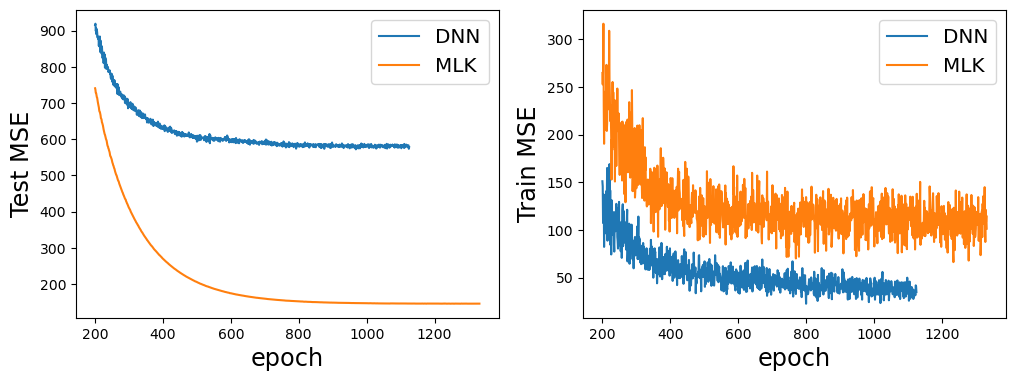

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_choose(ax[0],200,dnn_testloss)
plot_choose(ax[0],200,kernelnn_testloss)
ax[0].legend(["DNN","MLK"],fontsize="x-large")
ax[0].set_xlabel("epoch",fontsize="xx-large")
ax[0].set_ylabel("Test MSE",fontsize="xx-large")

plot_choose(ax[1],200,dnn_trainloss)
plot_choose(ax[1],200,kernelnn_trainloss)
ax[1].legend(["DNN","MLK"],fontsize="x-large")
ax[1].set_xlabel("epoch",fontsize="xx-large")
ax[1].set_ylabel("Train MSE",fontsize="xx-large")
plt.show()

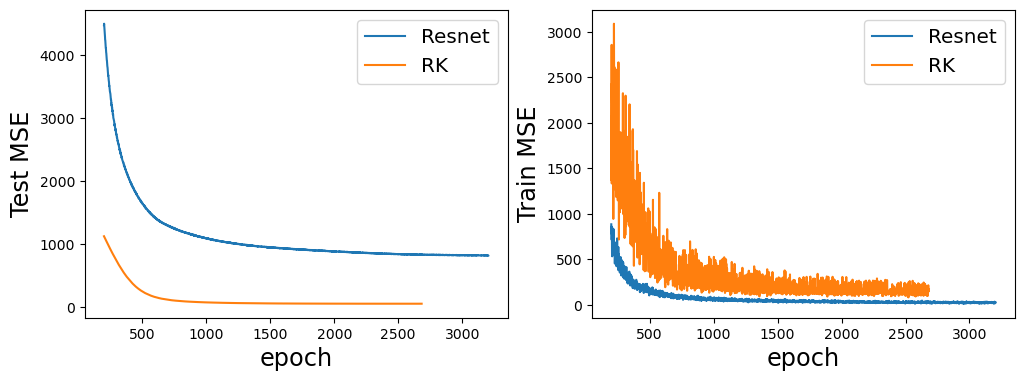

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_choose(ax[0],200,res_testloss)
plot_choose(ax[0],200,reskernel_testloss)
ax[0].legend(["Resnet","RK"],fontsize="x-large")
ax[0].set_xlabel("epoch",fontsize="xx-large")
ax[0].set_ylabel("Test MSE",fontsize="xx-large")

plot_choose(ax[1],200,res_trainloss)
plot_choose(ax[1],200,reskernel_trainloss)
ax[1].legend(["Resnet","RK"],fontsize="x-large")
ax[1].set_xlabel("epoch",fontsize="xx-large")
ax[1].set_ylabel("Train MSE",fontsize="xx-large")
plt.show()

## 3+. multi-layer learning (data splitting) 

In [35]:
#multi
split=2
layer=2
length=int(len(train_x)/layer)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff1=RandomFourierFeature(90,32,kernel='C',gamma=0.01)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=0.1)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(32, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)
        
train_loaderset=[] # there are "split" elements
netset=[]
optimizerset=[]
train_loss=[]
test_loss=[]

np.random.seed(0)
row_rand_array = np.arange(train_x.shape[0])
np.random.shuffle(row_rand_array)

train_loaderset1=[]
for l in range(layer): #split into different dataset
    curx=train_x.values[row_rand_array[l*length:(l+1)*length]]
    cury=train_y.values[row_rand_array[l*length:(l+1)*length]]
    nnx = torch.from_numpy(curx).float()
    nny = torch.squeeze(torch.from_numpy(cury).float()) 
    train_loader = DataLoader(mydataset(nnx, nny),batch_size=100, shuffle=True)
    train_loaderset1.append(train_loader)
    
for i in range(split):
    train_loaderset1=train_loaderset1[1:]+train_loaderset1[0:1]
    train_loaderset.append(train_loaderset1)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = KernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    netset.append(net)      
   
    optimizer1=[]
    optimizer1.append(optim.SGD([{'params': net.fc1.parameters()}],lr=8e-4,momentum=0.9,weight_decay=1e-4) )
    optimizer1.append(optim.SGD([{'params': net.fc2.parameters()}],lr=8e-4,momentum=0.9,weight_decay=1e-4) )
    optimizerset.append(optimizer1)
    
    train_loss.append(0)
    test_loss.append(0)
    
criterion=nn.MSELoss()    
loss=[]
alltrainloss=[[],[]]
alltestloss=[[],[]]
splkernel_trainloss=[]
splkernel_testloss=[]
t0 = time.time()
for epoch in range(3000): 
    for i in range(split):
        for l in range(layer):
            for x, y in train_loaderset[i][l]: #for batch, (x, y) in enumerate(train_loader): 
                # Data Splitting
                # every step, update a layer with smaller dataset 
                x, y = x.to(device), y.to(device)
                # Compute prediction error
                y_pred = netset[i](x)
                y_pred = torch.squeeze(y_pred)
                train_loss[i] = criterion(y_pred, y)
                alltrainloss[i].append(float(train_loss[i]))
                
                # Backpropagation
                optimizerset[i][l].zero_grad() 
                train_loss[i].backward()
                optimizerset[i][l].step()
            
    
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        for i in range(split):
            y_test_pred = netset[i](x)
            y_test_pred = torch.squeeze(y_test_pred)
            
            test_loss[i] = criterion(y_test_pred,y)
            alltestloss[i].append(float(test_loss[i]))
    
    if epoch>100 and float(sum(test_loss)/len(test_loss))>max(splkernel_testloss[-100:-1]):
        break
    
    if epoch % 100 == 0: 
        print(f'''epoch {epoch}
            Train set - loss: {sum(train_loss)/len(train_loss)}
            Test  set - loss: {sum(test_loss)/len(test_loss)}
            ''')
    splkernel_trainloss.append(float(sum(train_loss)/len(train_loss)))
    splkernel_testloss.append(float(sum(test_loss)/len(test_loss)))
            
        
dnn_fit = time.time() - t0
print("KernelNet(data splitting) complexity and model fitted in %.3f s" % dnn_fit)

epoch 0
            Train set - loss: 3840919.0
            Test  set - loss: 3766810.5
            
epoch 100
            Train set - loss: 1960.4461669921875
            Test  set - loss: 1622.9859619140625
            
epoch 200
            Train set - loss: 445.24639892578125
            Test  set - loss: 321.7451171875
            
epoch 300
            Train set - loss: 174.7880859375
            Test  set - loss: 104.94131469726562
            
epoch 400
            Train set - loss: 149.7131805419922
            Test  set - loss: 69.177001953125
            
epoch 500
            Train set - loss: 121.62632751464844
            Test  set - loss: 63.27022171020508
            
epoch 600
            Train set - loss: 145.73519897460938
            Test  set - loss: 62.390296936035156
            
epoch 700
            Train set - loss: 134.52052307128906
            Test  set - loss: 61.71498107910156
            
KernelNet(data splitting) complexity and model fitted in 29.316 s


In [250]:
print(y_test_pred,y)

tensor([1997.1702, 1993.8789, 1995.6584, 1995.7672, 1996.8228, 1996.7213,
        1996.9904, 1995.6162, 1998.5491, 1995.8969, 1994.4974, 1997.7358,
        1998.3770, 1998.1588, 1995.3534, 1996.0406, 1995.9950, 1996.0652,
        1994.4774, 1996.9832, 1995.3098, 1997.4091, 1995.2150, 1999.7844,
        1996.1118, 1993.2216, 1995.7085, 1999.0956, 1997.2065, 1998.2783,
        1994.8884, 1998.4110, 1996.8528, 1995.6199, 1996.3273, 1997.7012,
        1996.4800, 1996.6073, 1996.4469, 1995.1644, 1999.0885, 1997.8051,
        1996.9492, 1993.7906, 1997.6429, 1995.7955, 1995.2059, 1994.9615,
        1995.5201, 1999.4022, 1996.4585, 1994.8334, 1995.4595, 1998.7762,
        1997.2430, 1995.6790, 1997.4539, 1993.9318, 1995.8113, 1997.7725,
        1996.5688, 1992.9519, 1999.6930, 1996.7991, 1993.5320, 1995.7893,
        1998.8574, 1994.9900, 1996.3215, 1996.2124, 1998.7998, 1998.7092,
        1996.8900, 1996.8617, 1997.4259, 1996.2821, 1998.1990, 1997.0225,
        1995.6051, 1998.5186, 1996.206

In [251]:
#original
#predict
temp=[]
parset=[]
for spl in range(split):
    par1=optimizerset[spl][0].param_groups[0]['params']
    for jj in range(1,split):
        par1=par1+optimizerset[spl][jj].param_groups[0]['params']
    parset.append(par1)
        
for spl in range(split):
    par=parset[spl]
    for i in range(len(train_x)):
        x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
        x0 = x0.to(device)
        pred = netset[spl](x0)
        fi=torch.tensor([])
        for j in range(len(par)):
            par[j].grad.data.zero_()
        pred.backward()   
        for j in range(len(par)): 
            fi=torch.cat([fi,par[j].grad.reshape(-1)])
        fi=fi.reshape(1,-1)
        if i==0:
            Fi=fi
        else:
            Fi=torch.cat([Fi,fi])   
    print(Fi.shape)
    temp.append(torch.linalg.inv(Fi.T @ Fi))
    
length=[]
coverage=0
mark=0
for i in range(len(test_x)):
    fFFf=0
    for spl in range(split):
        par=parset[spl]
        x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
        x0 = x0.to(device)
        pred = netset[spl](x0)
        #print(pred.detach().numpy()[0][0],test_y[i])
        par=parset[spl]
        f0=torch.tensor([])
        for j in range(len(par)):
            par[j].grad.data.zero_()
        pred.backward()
        for j in range(len(par)):
            f0=torch.cat([f0,par[j].grad.reshape(-1)])
        f0=f0.reshape(-1,1)
        fFFf=fFFf+f0.T @ temp[spl] @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=1.96*np.sqrt(float(fFFf/split**2+1))*np.sqrt(splkernel_trainloss[-1])
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)

torch.Size([700, 273])
torch.Size([700, 273])
n-p: 427  mark: 300
length 54.98014755259159
95 coverage 0.9133333333333333


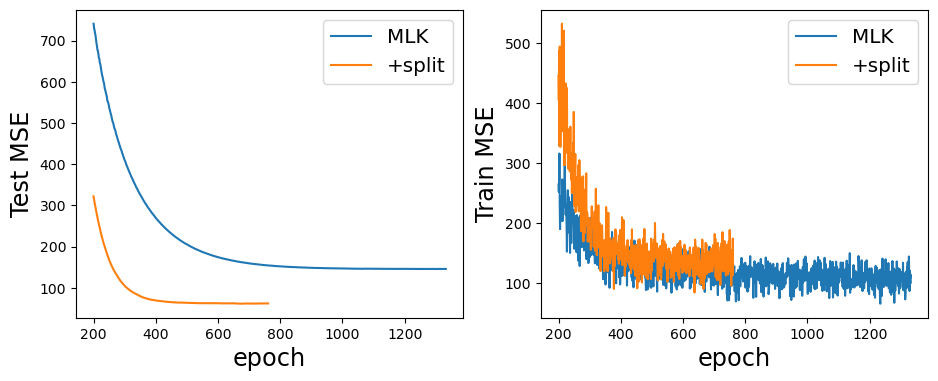

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_choose(ax[0],200,kernelnn_testloss)
plot_choose(ax[0],200,splkernel_testloss)
ax[0].legend(["MLK","+split"],fontsize="x-large")
ax[0].set_xlabel("epoch",fontsize="xx-large")
ax[0].set_ylabel("Test MSE",fontsize="xx-large")

plot_choose(ax[1],200,kernelnn_trainloss)
plot_choose(ax[1],200,splkernel_trainloss)
ax[1].legend(["MLK","+split"],fontsize="x-large")
ax[1].set_xlabel("epoch",fontsize="xx-large")
ax[1].set_ylabel("Train MSE",fontsize="xx-large")
plt.show()

## 4+. residual learning (data splitting) 

In [44]:
#res
split=2
layer=2
length=int(len(train_x)/layer)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff0=RandomFourierFeature(90,32,kernel='C',gamma=0.01)
rff1=RandomFourierFeature(8,8,kernel='G',gamma=0.1)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(32,8,rff1)
        self.fc2 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)
        
train_loaderset=[] # there are "split" elements
netset=[]
optimizerset=[]
alltrainloss=[[],[],[]]
alltestloss=[[],[],[]]
train_loss=[]
test_loss=[]

np.random.seed(0)
row_rand_array = np.arange(train_x.shape[0])
np.random.shuffle(row_rand_array)

train_loaderset1=[]
for l in range(layer): #split into different dataset
    curx=train_x.values[row_rand_array[l*length:(l+1)*length]]
    cury=train_y.values[row_rand_array[l*length:(l+1)*length]]
    nnx = torch.from_numpy(curx).float()
    nny = torch.squeeze(torch.from_numpy(cury).float()) 
    train_loader = DataLoader(mydataset(nnx, nny),batch_size=100, shuffle=True)
    train_loaderset1.append(train_loader)
    
for i in range(split):
    train_loaderset1=train_loaderset1[1:]+train_loaderset1[0:1]
    train_loaderset.append(train_loaderset1)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    netset.append(net)      
   
    optimizer1=[]
    optimizer1.append(optim.SGD([{'params': net.rblock1.parameters()}],lr=8e-7,momentum=0.9,weight_decay=1e-4) )
    optimizer1.append(optim.SGD([{'params': net.fc2.parameters()}],lr=8e-7,momentum=0.9,weight_decay=1e-4) )
    optimizerset.append(optimizer1)
    
    train_loss.append(0)
    test_loss.append(0)
    
criterion=nn.MSELoss()    
loss=[]
splreskernel_trainloss=[]
splreskernel_testloss=[]
t0 = time.time()
for epoch in range(3000): 
    for i in range(split):
        for l in range(layer):
            for x, y in train_loaderset[i][l]: #for batch, (x, y) in enumerate(train_loader): 
                # Data Splitting
                # every step, update a layer with smaller dataset 
                x, y = x.to(device), y.to(device)
                # Compute prediction error
                y_pred = netset[i](x)
                y_pred = torch.squeeze(y_pred)
                train_loss[i] = criterion(y_pred, y)
                alltrainloss[i].append(float(train_loss[i]))
                
                # Backpropagation
                optimizerset[i][l].zero_grad() 
                train_loss[i].backward()
                optimizerset[i][l].step()
            
    
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        for i in range(split):
            y_test_pred = netset[i](x)
            y_test_pred = torch.squeeze(y_test_pred)
            
            test_loss[i] = criterion(y_test_pred,y)
            alltestloss[i].append(float(test_loss[i]))
    
    if epoch>100 and float(sum(test_loss)/len(test_loss))>max(splreskernel_testloss[-100:-1]):
        break
    
    if epoch % 100 == 0: 
        print(f'''epoch {epoch}
            Train set - loss: {sum(train_loss)/len(train_loss)}
            Test  set - loss: {sum(test_loss)/len(test_loss)}
            ''')
    splreskernel_trainloss.append(float(sum(train_loss)/len(train_loss)))
    splreskernel_testloss.append(float(sum(test_loss)/len(test_loss)))
            
        
dnn_fit = time.time() - t0
print("ResKernelNet(data splitting) complexity and model fitted in %.3f s" % dnn_fit)

epoch 0
            Train set - loss: 3975904.0
            Test  set - loss: 3994657.5
            
epoch 100
            Train set - loss: 296.52130126953125
            Test  set - loss: 207.2788848876953
            
epoch 200
            Train set - loss: 194.26126098632812
            Test  set - loss: 133.08895874023438
            
epoch 300
            Train set - loss: 237.30490112304688
            Test  set - loss: 119.22537231445312
            
epoch 400
            Train set - loss: 201.62860107421875
            Test  set - loss: 109.18122863769531
            
epoch 500
            Train set - loss: 185.05657958984375
            Test  set - loss: 102.56901550292969
            
epoch 600
            Train set - loss: 174.0899200439453
            Test  set - loss: 97.26622009277344
            
epoch 700
            Train set - loss: 227.00128173828125
            Test  set - loss: 93.73888397216797
            
epoch 800
            Train set - loss: 177.105926513671

In [45]:
print(y_test_pred,y)

tensor([2006.3701, 1994.5854, 1987.0378, 2002.3286, 1993.1250, 2005.1187,
        2010.1401, 2009.5552, 1987.3774, 1979.5270, 1997.9641, 1991.9902,
        1997.8845, 1988.7111, 1992.1523, 1996.2487, 1999.8342, 2007.5146,
        1990.2456, 1995.5233, 1996.2283, 2000.9380, 2004.0911, 2006.7246,
        2000.3423, 2002.5917, 2000.9788, 1986.6699, 1997.2458, 1999.9534,
        1997.7313, 1988.1974, 2008.3066, 2007.8010, 2002.2021, 1973.8435,
        1989.7739, 2002.1118, 2005.3763, 1986.0435, 2010.8610, 1993.7887,
        2007.7610, 1996.8593, 1988.1901, 2002.3745, 1995.9009, 1994.7540,
        1997.1561, 1993.1208, 1998.6521, 1993.9595, 1994.0507, 1999.3889,
        2005.6637, 2002.3635, 1988.0470, 1989.1531, 2002.6108, 1996.1553,
        1991.2749, 2001.6497, 2006.5493, 2000.4381, 1996.1321, 2002.0979,
        2000.8938, 2007.1356, 2005.3573, 1996.6443, 1992.4891, 2000.0609,
        1995.4155, 1997.0940, 1992.5762, 1994.3831, 1998.8092, 1996.1702,
        1995.6785, 1983.3457, 1990.716

In [46]:
#original
#predict
temp=[]
parset=[]
for spl in range(split):
    par1=optimizerset[spl][0].param_groups[0]['params']
    for jj in range(1,split):
        par1=par1+optimizerset[spl][jj].param_groups[0]['params']
    parset.append(par1)
        
for spl in range(split):
    par=parset[spl]
    for i in range(len(train_x)):
        x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
        x0 = x0.to(device)
        pred = netset[spl](x0)
        fi=torch.tensor([])
        for j in range(len(par)):
            par[j].grad.data.zero_()
        pred.backward()   
        for j in range(len(par)): 
            fi=torch.cat([fi,par[j].grad.reshape(-1)])
        fi=fi.reshape(1,-1)
        if i==0:
            Fi=fi
        else:
            Fi=torch.cat([Fi,fi])   
    print(Fi.shape)
    temp.append(torch.linalg.inv(Fi.T @ Fi))
    
length=[]
coverage=0
mark=0
for i in range(len(test_x)):
    fFFf=0
    for spl in range(split):
        par=parset[spl]
        x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
        x0 = x0.to(device)
        pred = netset[spl](x0)
        #print(pred.detach().numpy()[0][0],test_y[i])
        par=parset[spl]
        f0=torch.tensor([])
        for j in range(len(par)):
            par[j].grad.data.zero_()
        pred.backward()
        for j in range(len(par)):
            f0=torch.cat([f0,par[j].grad.reshape(-1)])
        f0=f0.reshape(-1,1)
        fFFf=fFFf+f0.T @ temp[spl] @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=1.96*np.sqrt(float(fFFf/split**2+1))*np.sqrt(splreskernel_testloss[-1])
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)

torch.Size([700, 345])
torch.Size([700, 345])
n-p: 355  mark: 263
length 48.71334347452904
95 coverage 0.9049429657794676


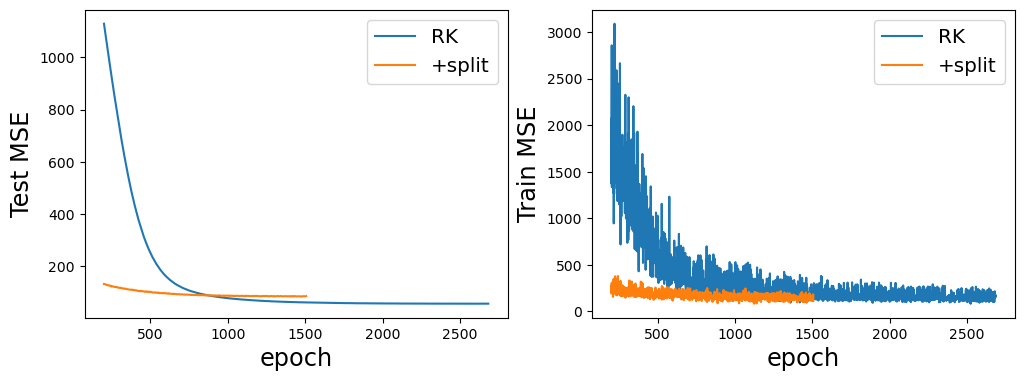

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_choose(ax[0],200,reskernel_testloss)
plot_choose(ax[0],200,splreskernel_testloss)
ax[0].legend(["RK","+split"],fontsize="x-large")
ax[0].set_xlabel("epoch",fontsize="xx-large")
ax[0].set_ylabel("Test MSE",fontsize="xx-large")

plot_choose(ax[1],200,reskernel_trainloss)
plot_choose(ax[1],200,splreskernel_trainloss)
ax[1].legend(["RK","+split"],fontsize="x-large")
ax[1].set_xlabel("epoch",fontsize="xx-large")
ax[1].set_ylabel("Train MSE",fontsize="xx-large")
plt.show()